In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import the data covert that into a convenient data
PATH= '/home/ac-optimus/data_science/recommendation_sys/ratings_small.csv'
df = pd.read_csv(PATH, sep= ",")
# df = pd.read_csv(PATH, sep= ",")
df.shape

(100004, 4)

In [3]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [4]:
# this gave me a good plot
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
df.head()

,userId,movieId,rating
67795,472,3108,4.0
22823,160,1244,4.0
42647,306,1213,5.0
60380,439,39,4.0
14371,94,1961,4.0


In [6]:
num_rows = df.shape[0]
train, test = df.copy(deep = True), df[int(num_rows*0.8):].copy(deep = True)
train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0
train = shuffle(train)

<ipython-input-6-75ff325d5135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0


In [7]:
user_movie_rating =train.groupby(['userId','movieId'])['rating'].max().unstack().fillna(0)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_movie_rating.shape
print ("We have {} users in our user-movie matrix.".format(user_movie_rating.shape[0]))
print ("We have {} movies in our user-movie matrix.".format(user_movie_rating.shape[1]))


We have 671 users in our user-movie matrix.
We have 9066 movies in our user-movie matrix.


In [9]:
correlation_matrix = user_movie_rating.T.corr()
correlation_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.003459,-0.002775,0.036998,0.016036,-0.002372,0.052949,-0.004306,0.011734,-0.002546,...,-0.002990,-0.002245,-0.009038,0.017024,-0.002405,-0.003240,-0.001638,0.075193,-0.002033,0.018540
2,-0.003459,1.000000,0.143760,0.073912,0.087440,-0.004618,0.206681,0.109351,0.106250,0.050878,...,0.376754,0.063397,0.039295,0.106377,0.443786,0.355474,0.055583,0.025557,0.097528,0.095685
3,-0.002775,0.143760,1.000000,0.077892,0.132220,0.049650,0.196326,0.191486,0.130400,0.078610,...,0.127076,0.068551,0.116449,0.134451,0.181100,0.148748,0.038669,0.076846,0.086750,0.113979
4,0.036998,0.073912,0.077892,1.000000,0.118122,0.034148,0.210149,0.176461,0.013563,0.133997,...,0.096874,0.046686,0.080735,0.189226,0.087562,0.044117,0.025666,0.101723,0.058901,0.137879
5,0.016036,0.087440,0.132220,0.118122,1.000000,0.052333,0.056923,0.133887,0.080178,0.008257,...,0.137033,0.018699,0.082606,0.146623,0.125344,0.052443,0.050544,0.019846,0.025037,0.144517


In [10]:
# person similarity based

# when we want to find a recommendaiton for a user.
# we compute the correlation(cetered cosine or person correlation, making a saperate column would be a good idea)
# with all the users in the utility matrix
# return the top movies that user had not watched yet and recommend that movie
# main aim is to fill the values that is it.
# central_mean.iloc[0].corr(central_mean.iloc[1])
# user_movie_rating= central_mean

In [12]:
def error(y_hat, y):
    # MSE
    y_hat = np.array(y_hat)
    y = np.array(y)
    MSE_ = (y_hat- y)**2
    MSE = MSE_.sum()/len(y_hat)
    return MSE

### Similarity based

In [13]:
def PredictMovieRating(user_i, movie_i, corr_mat, user_movie_rating, k):
    # for user x
    # rxi = sum over knn (sxy*ryi)/sum over all the knn similarities
    all_neighbours = corr_mat.loc[user_i]
    all_neighbours = all_neighbours.drop(user_i)
    topk_neighbours = all_neighbours.sort_values(ascending=False)[:k]  # knn
    # knn user ids
    knn = topk_neighbours.index.tolist()
#     return knn
    sum_sim = sum([corr_mat[user_i][user_j] for user_j in knn])
    weighted_sum_sim = sum([corr_mat[user_i][user_j]*user_movie_rating[movie_i][user_j] 
                           for user_j in knn])
    predicted_rating = weighted_sum_sim/sum_sim
    return predicted_rating

In [14]:
y_hat = []
for i in test.index:
    user_i, movie_j = map(int,[ test.loc[i]['userId'], test.loc[i]['movieId']])
    # make the prediction here
    predicted_rating = PredictMovieRating(user_i, movie_j, correlation_matrix, user_movie_rating, 4)
    y_hat.append(predicted_rating)

# compute the error here.


In [15]:
y= test['rating'].tolist()

In [16]:
# compute error
error(np.nan_to_num(np.array(y_hat)), y)

166392.77632292098

In [17]:
# to compute error
# create a new matrix that has ratings based on similarities 
# compare with the y and yhat and get the error
# we can use the same split of test and train as in assignment.

In [16]:
%%time

# looking for optimal k
y= test['rating']
errors = {}
for k in range(1, 40):
    y_hat = []
    for i in test.index:
        user_i, movie_j = map(int,[test.loc[i]['userId'], 
                                   test.loc[i]['movieId']])
        # make the prediction here
        predicted_rating = PredictMovieRating(user_i, 
                                              movie_j, 
                                              correlation_matrix, 
                                              user_movie_rating, k)
        y_hat.append(predicted_rating)
    error_i = error(np.nan_to_num(np.array(y_hat)), y)        
    errors[k]=error_i


CPU times: user 27min 26s, sys: 1.17 s, total: 27min 28s
Wall time: 27min 35s


Text(0.5, 1.0, 'optimal neighbour search')

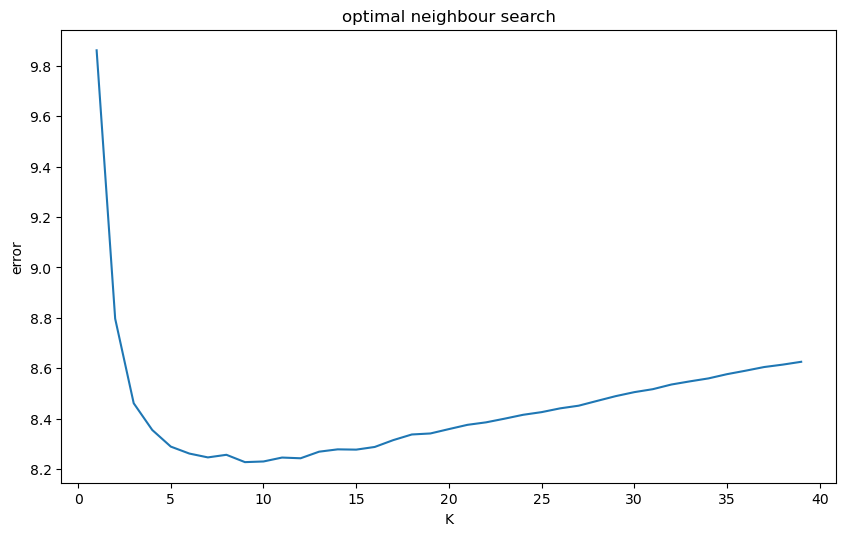

In [17]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(errors.keys(), errors.values())
plt.xlabel('K')
plt.ylabel('error')
plt.title('optimal neighbour search')

### Optimal K=9

In [ ]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
y_hat = []
for i in test.index:
    user_i, movie_j = map(int,[test.loc[i]['userId'], 
                               test.loc[i]['movieId']])
    # make the prediction here
    predicted_rating = PredictMovieRating(user_i, 
                                          movie_j, 
                                          correlation_matrix, 
                                          user_movie_rating, 9)
    y_hat.append(predicted_rating)
error_i = error(np.nan_to_num(np.array(y_hat)), y)        


### MSE

In [53]:
y= test['rating'].tolist()
# compute error
error(np.nan_to_num(np.array(y_hat)), y);

In [54]:
# Pred
error(y_hat, test['rating'])

8.22763586678015

In [30]:
test['prediction'] = y_hat
test.head()

,userId,movieId,rating,prediction
86359,577,3977,4.0,1.674462
42776,306,1968,4.0,3.759566
39633,289,2687,4.0,0.000000
85187,572,104913,4.5,0.000000
32566,235,2987,4.5,0.694104


In [31]:
from collections import Counter
user_freq_dict = Counter(test['userId'].tolist())
max_voting = max(user_freq_dict.values())
for i in user_freq_dict:
    if user_freq_dict[i] == max_voting:
        user_choice =i

In [32]:
one_user= test.loc[(test['userId'] == user_choice)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
80352,547,55247,5.0,0.108135
79112,547,2797,5.0,2.258228
78757,547,1265,5.0,2.916521
78725,547,1219,5.0,3.415835
79234,547,3253,5.0,1.602545


### Recall and Precision

In [33]:
relevance_threshold = 2
recommended_movies = set(one_user.loc[(one_user['prediction'] >= relevance_threshold)]['movieId'].tolist())
relavent_movies = set(one_user.loc[(one_user['rating'] >= relevance_threshold)]['movieId'].tolist())
len(relavent_movies), len(recommended_movies)

(454, 40)

In [34]:
recommended_movies_intersection_relavant_movies = [i for i in recommended_movies if i in relavent_movies]
recommended_movies_intersection_relavant_movies;

In [35]:
len(recommended_movies), len(recommended_movies_intersection_relavant_movies), len(relavent_movies)

(40, 39, 454)

In [36]:
recall = len(recommended_movies_intersection_relavant_movies)/len(relavent_movies)
precision = len(recommended_movies_intersection_relavant_movies)/len(recommended_movies)

In [37]:
precision, recall

(0.975, 0.08590308370044053)

In [38]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.15789473684210528

### Recall@k and Precision@k
- recall and precision on top k predictions

In [46]:
k=18
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
top_k_predictions_df.head()

,userId,movieId,rating,prediction
78630,547,953,5.0,3.674033
78725,547,1219,5.0,3.415835
78608,547,920,5.0,3.183452
78920,547,1997,3.0,3.122419
79226,547,3201,3.0,3.063674


In [47]:
relevance_threshold=3.5
top_k_movies_recommended = set(top_k_predictions_df.loc[(top_k_predictions_df['prediction'] >= relevance_threshold)]['movieId'].tolist())
top_k_movies_relevant = set(top_k_predictions_df.loc[(top_k_predictions_df['rating'] >= relevance_threshold)]['movieId'].tolist())
# top_k_predictions_df['rating']

In [48]:
recommended_movies_intersection_relavant_movies = [i for i in top_k_movies_recommended
                                                   if i in top_k_movies_relevant]
recommended_movies_intersection_relavant_movies

[953]

In [49]:
len(top_k_movies_recommended), len(recommended_movies_intersection_relavant_movies), len(top_k_movies_relevant)

(1, 1, 13)

In [55]:
if len(top_k_movies_relevant)!=0:
    recall = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_relevant)
else:
    recall = 1
if len(top_k_movies_recommended)!=0:
    precision = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_recommended)
else:
    precision = 1

In [56]:
precision, recall

(1.0, 0.07692307692307693)

In [57]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.14285714285714288